In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Layer, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from scipy.optimize import minimize

In [2]:
random_train_imgs = np.load("data/kmnist-randomized-train-imgs.npz")["arr_0"]
random_train_labels = np.load("data/kmnist-randomized-train-labels.npz")["arr_0"]
random_test_imgs = np.load("data/kmnist-randomized-test-imgs.npz")["arr_0"]
random_test_labels = np.load("data/kmnist-randomized-test-labels.npz")["arr_0"]

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(random_train_imgs, random_train_labels, test_size=0.1, shuffle=False)

In [4]:
X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

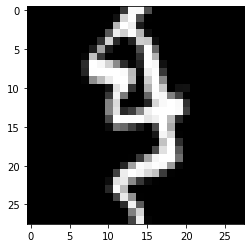

In [5]:
plt.imshow(X_train[10], cmap="gray")

In [6]:
categories = len(np.unique(y_train))
categories

10

In [7]:
y_train = to_categorical(y_train, categories)
y_valid = to_categorical(y_valid, categories)

In [8]:
X_test = random_test_imgs
y_test = random_test_labels

In [9]:
X_test = X_test.astype("float32") / 255

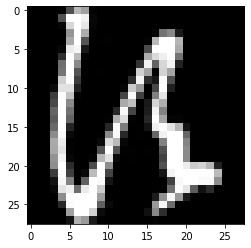

In [10]:
plt.imshow(X_test[10], cmap="gray")

In [11]:
categories = len(np.unique(y_test))
categories

10

In [12]:
y_test = to_categorical(y_test, categories)
y_test[10]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [13]:
!git clone "https://github.com/fabiodimarco/tf-levenberg-marquardt.git"

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 29 (delta 15), reused 19 (delta 9), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [14]:
from tf_levenberg_marquardt import levenberg_marquardt as lm

In [15]:
op_histories = []

In [17]:
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1000, activation="relu"),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax")
])

mc = ModelCheckpoint("sgd_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories.append(history)


mc = ModelCheckpoint("lm_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1000, activation="relu"),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax")
])

model_wrapper = lm.ModelWrapper(model)
model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model_wrapper.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories.append(history)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53952/54000 [============================>.] - ETA: 0s - loss: 0.3813 - accuracy: 0.8838
Epoch 00001: val_accuracy improved from -inf to 0.93600, saving model to sgd_op.h5
54000/54000 [==============================] - 17s 315us/sample - loss: 0.3812 - accuracy: 0.8839 - val_loss: 0.2227 - val_accuracy: 0.9360
Epoch 2/10
53920/54000 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9541
Epoch 00002: val_accuracy improved from 0.93600 to 0.94133, saving model to sgd_op.h5
54000/54000 [==============================] - 15s 286us/sample - loss: 0.1519 - accuracy: 0.9541 - val_loss: 0.1987 - val_accuracy: 0.9413
Epoch 3/10
53888/54000 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9743
Epoch 00003: val_accuracy improved from 0.94133 to 0.95133, saving model to sgd_op.h5
54000/54000 [==============================] - 16s 302us/sample - loss: 0.0879 - accuracy: 0.9743 - val_loss: 0.1625

In [21]:
op_histories[0].model.evaluate(X_test, y_test, verbose=0)

[0.38943281504139304, 0.9184]

In [22]:
op_histories[1].model.evaluate(X_test, y_test, verbose=0)

[1.6453197278976441, 0.82]

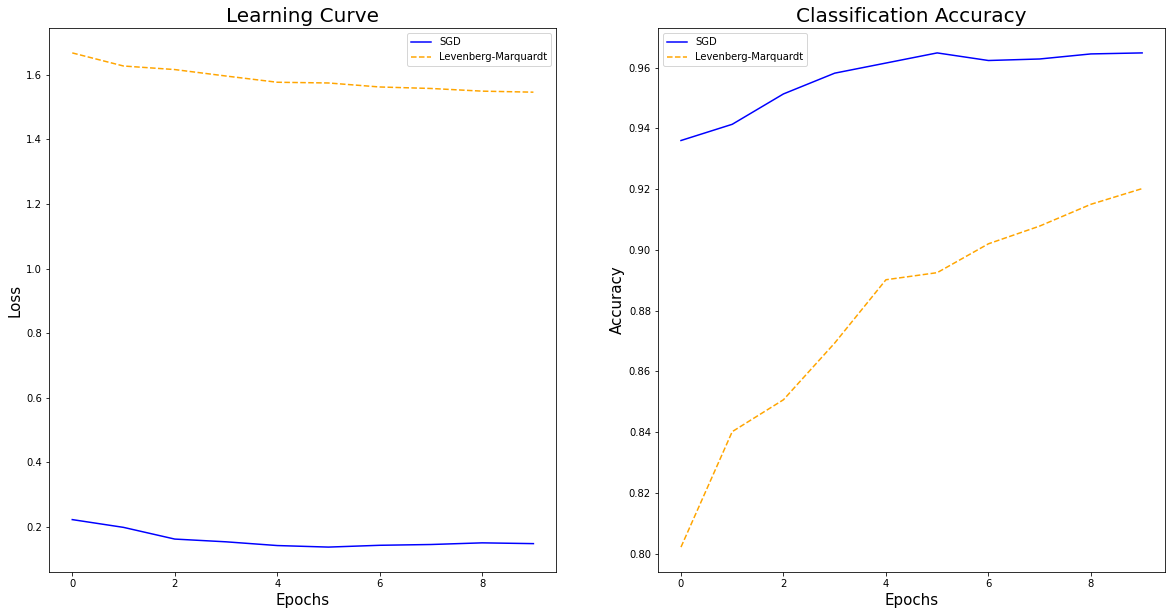

In [31]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Learning Curve', fontdict={"fontsize":20})
plt.plot(op_histories[0].history['val_loss'], color='blue', label='SGD', ls="-")
plt.plot(op_histories[1].history['val_loss'], color='orange', label='Levenberg-Marquardt', ls="--")
# plt.plot(history3.history['val_loss'], color='red', label='lr=0.01 and big units', ls="-.")
# plt.plot(history4.history['val_loss'], color='black', label='lr=0.1 and big units', ls=":")
# plt.plot(history5.history['val_loss'], color='green', label='lr=0.5 and big units', ls=":")
plt.xlabel("Epochs", fontdict={"fontsize":15})
plt.ylabel("Loss", fontdict={"fontsize":15})
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Classification Accuracy', fontdict={"fontsize":20})
plt.plot(op_histories[0].history['val_accuracy'], color='blue', label='SGD', ls="-")
plt.plot(op_histories[1].history['val_accuracy'], color='orange', label='Levenberg-Marquardt', ls="--")
# plt.plot(history3.history['val_accuracy'], color='red', label='lr=0.01 and big units', ls="-.")
# plt.plot(history4.history['val_accuracy'], color='black', label='lr=0.1 and big units', ls=":")
# plt.plot(history5.history['val_accuracy'], color='green', label='lr=0.5 and big units', ls=":")
plt.xlabel("Epochs", fontdict={"fontsize":15})
plt.ylabel("Accuracy", fontdict={"fontsize":15})
plt.legend()
plt.show()

In [35]:
op_histories4 = []

In [40]:
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(100, activation="relu"),
    Dense(50, activation="relu"),
    Dense(10, activation="softmax")
])


mc = ModelCheckpoint("sgd_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])

model_wrapper = lm.ModelWrapper(tf.keras.models.clone_model(model))
model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories4.append(history)


mc = ModelCheckpoint("lm_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

# model = Sequential([
#     Flatten(input_shape=X_train.shape[1:]),
#     Dense(1000, activation="relu"),
#     Dense(512, activation="relu"),
#     Dense(10, activation="softmax")
# ])

history = model_wrapper.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories4.append(history)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53920/54000 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.8578
Epoch 00001: val_accuracy improved from -inf to 0.90867, saving model to sgd_op.h5
54000/54000 [==============================] - 7s 138us/sample - loss: 0.4613 - accuracy: 0.8579 - val_loss: 0.3087 - val_accuracy: 0.9087
Epoch 2/10
53792/54000 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9311
Epoch 00002: val_accuracy did not improve from 0.90867
54000/54000 [==============================] - 6s 114us/sample - loss: 0.2240 - accuracy: 0.9312 - val_loss: 0.4151 - val_accuracy: 0.8670
Epoch 3/10
53728/54000 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9511
Epoch 00003: val_accuracy improved from 0.90867 to 0.93900, saving model to sgd_op.h5
54000/54000 [==============================] - 6s 104us/sample - loss: 0.1617 - accuracy: 0.9510 - val_loss: 0.2117 - val_accuracy: 0.9390
Epoch 4/10

In [42]:
op_histories4

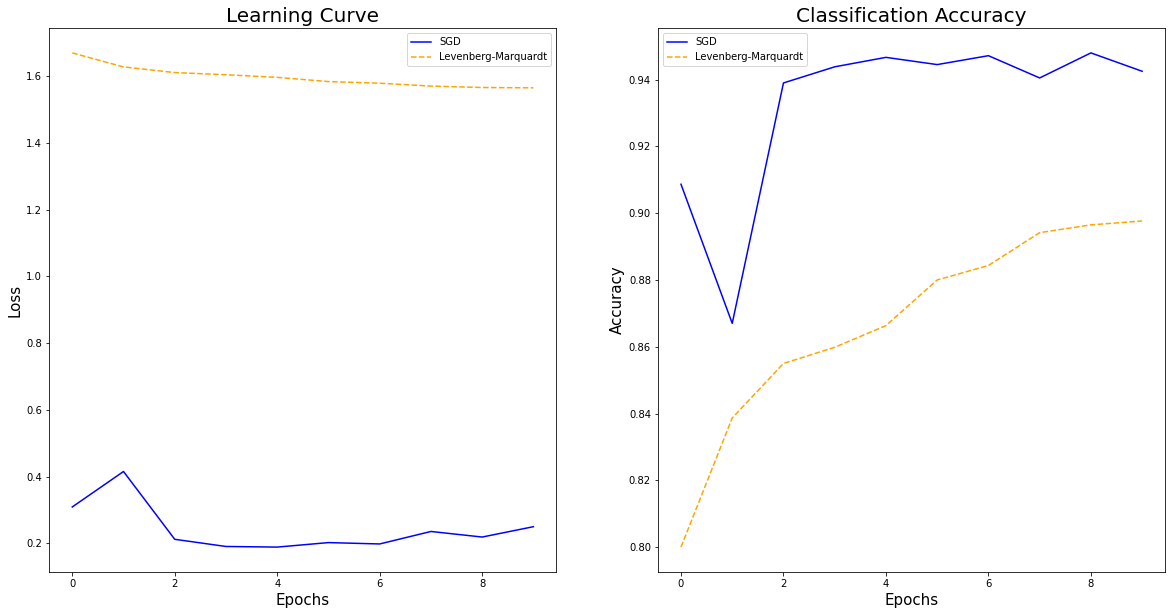

In [43]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Learning Curve', fontdict={"fontsize":20})
plt.plot(op_histories4[3].history['val_loss'], color='blue', label='SGD', ls="-")
plt.plot(op_histories4[4].history['val_loss'], color='orange', label='Levenberg-Marquardt', ls="--")
# plt.plot(history3.history['val_loss'], color='red', label='lr=0.01 and big units', ls="-.")
# plt.plot(history4.history['val_loss'], color='black', label='lr=0.1 and big units', ls=":")
# plt.plot(history5.history['val_loss'], color='green', label='lr=0.5 and big units', ls=":")
plt.xlabel("Epochs", fontdict={"fontsize":15})
plt.ylabel("Loss", fontdict={"fontsize":15})
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Classification Accuracy', fontdict={"fontsize":20})
plt.plot(op_histories4[3].history['val_accuracy'], color='blue', label='SGD', ls="-")
plt.plot(op_histories4[4].history['val_accuracy'], color='orange', label='Levenberg-Marquardt', ls="--")
# plt.plot(history3.history['val_accuracy'], color='red', label='lr=0.01 and big units', ls="-.")
# plt.plot(history4.history['val_accuracy'], color='black', label='lr=0.1 and big units', ls=":")
# plt.plot(history5.history['val_accuracy'], color='green', label='lr=0.5 and big units', ls=":")
plt.xlabel("Epochs", fontdict={"fontsize":15})
plt.ylabel("Accuracy", fontdict={"fontsize":15})
plt.legend()
plt.show()

In [45]:
op_histories4[3].model.evaluate(X_test, y_test, verbose=0)

[0.547992284052074, 0.8862]

In [47]:
op_histories4[4].model.evaluate(X_test, y_test, verbose=0)

[1.6778834701538086, 0.786]

In [48]:
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(100, activation="relu"),
    Dense(50, activation="relu"),
    Dense(10, activation="softmax")
])


mc = ModelCheckpoint("sgd_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])

model_wrapper = lm.ModelWrapper(tf.keras.models.clone_model(model))
model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.3),
    loss=lm.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories4.append(history)


mc = ModelCheckpoint("lm_op.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

# model = Sequential([
#     Flatten(input_shape=X_train.shape[1:]),
#     Dense(1000, activation="relu"),
#     Dense(512, activation="relu"),
#     Dense(10, activation="softmax")
# ])

history = model_wrapper.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid), callbacks=[mc], shuffle=True)
op_histories4.append(history)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
53792/54000 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.8550
Epoch 00001: val_accuracy improved from -inf to 0.88717, saving model to sgd_op.h5
54000/54000 [==============================] - 9s 169us/sample - loss: 0.4647 - accuracy: 0.8551 - val_loss: 0.3648 - val_accuracy: 0.8872
Epoch 2/5
53728/54000 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9338
Epoch 00002: val_accuracy improved from 0.88717 to 0.93350, saving model to sgd_op.h5
54000/54000 [==============================] - 7s 123us/sample - loss: 0.2175 - accuracy: 0.9338 - val_loss: 0.2342 - val_accuracy: 0.9335
Epoch 3/5
53920/54000 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9514
Epoch 00003: val_accuracy improved from 0.93350 to 0.94283, saving model to sgd_op.h5
54000/54000 [==============================] - 7s 123us/sample - loss: 0.1574 - accuracy: 0.9515 - val_loss: 0.2071 - val